In [2]:
import pandas as pd
import numpy as np
import warnings
import datetime

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("bookinghistory.csv", low_memory=False)

In [4]:
df.dropna(subset=['battery_level_at_start','battery_level_at_end'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df.drop(['id', 'bookind_id', 'distance', 'driver_login', 'start_location', 'end_location', 'trip_fare', 'car_group', 'start_zone_name', 'end_zone_name', 'booking_end', 'cp__end', 'cp__start', 'customer_id', 'ignore_relocation_bonus', 'associated_pfm', 'not_invoiced', 'associated_pfr', 'already_invoiced', 'last_update', 'rating', 'car_histoy_match', 'rating_description', 'notif_booking_finished_no_pfr', 'notif_booking_ongoing_no_reservation', 'pk_driver', 'reason_for_no_pfr', 'bonus_malus', 'account', 'car_history_match', 'otoqi_reference', 'city'], axis=1, inplace = True)


### Sort dataframe by date & delta battery column

In [6]:
df['start_date_time']= pd.to_datetime(df['booking_start_date__date'].astype(str), infer_datetime_format=True)
df['end_date_time']= pd.to_datetime(df['booking_end_date__date'].astype(str), infer_datetime_format=True)

In [7]:
df = df.sort_values(by="start_date_time")

In [8]:
df = df.drop_duplicates(subset=['booking_id'], keep='first')

In [9]:
df["charging"] = (df['battery_level_at_end']-df['battery_level_at_start']>1)

In [10]:
df['mileage_end'] = df[["mileage_end", "mileage_start"]].max(axis=1)

### Remove bookings with no change of battery

In [11]:
df['battery_level_at_end'] = pd.to_numeric(df['battery_level_at_end']).astype(int)
df['battery_level_at_start'] = pd.to_numeric(df['battery_level_at_start']).astype(int)

In [12]:
df['delta'] = df['battery_level_at_end']-df['battery_level_at_start']

In [13]:
df['battery_changed'] = (df['battery_level_at_end']-df['battery_level_at_start']!=0)

In [14]:
# df = df[df['battery_changed']==True]

In [15]:
df.drop(['battery_changed'], axis=1, inplace = True)

## Get total distance in bookings

In [16]:
df['month'] = df['start_date_time'].dt.month
month_dict = {2:"Février", 3: "Mars", 4:"Avril", 5: "Mai", 6: "Juin"}
df['month'] = df['month'].map(month_dict)

In [17]:
df['car_model'] = df['car_model'].replace({'Zoe': 'ZOE'})

### Utils

In [18]:
def getSessions(dataframe):
    """
        Returns charging sessions for input dataframe with only one plate number
    """
    dataframe.reset_index(drop=True, inplace=True)
    plate = dataframe.loc[0, 'plate_number']
    model = dataframe.loc[0, 'car_model']
    dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
    dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
    dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
    dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
    dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
    for index in range(len(dataframe)):
        if dataframe.loc[index, 'battery_drop']/(dataframe.loc[index, 'delta_hours']+1) > 5:
            dataframe.loc[index, 'battery_level_at_start'] = dataframe.loc[index, 'last_end_battery']
            dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
            dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
            dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
            dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
            dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
            dataframe['delta'] = dataframe['battery_level_at_end']-dataframe['battery_level_at_start']
        if (dataframe.loc[index, 'battery_level_at_start'] - dataframe.loc[index, 'battery_level_at_end'])/(dataframe.loc[index, 'duration']+1)>30:
            dataframe.loc[index, 'battery_level_at_end'] = dataframe.loc[index, 'battery_level_at_start']
            dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
            dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
            dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
            dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
            dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
            dataframe['delta'] = dataframe['battery_level_at_end']-dataframe['battery_level_at_start']

    
    dataframe.reset_index(drop=True, inplace=True)
    dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
    dataframe['was_charging']=(dataframe['battery_level_at_start']-dataframe['last_end_battery']>0)
    dataframe["charging"] = (dataframe['battery_level_at_end']-dataframe['battery_level_at_start']>0)
    charging_sessions = []
    index = 0
    current_start = 0
    start = ""
    start_battery = 0
    current_last = 0
    open_booking = False
    while index < len(dataframe) :
        if open_booking: # car was charging
            if not dataframe.loc[index, 'charging']: # car is not charging anymore --> close session
                open_booking = False
                if dataframe.loc[index, 'was_charging']:
                    charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index, 'start_date_time'], start_battery, dataframe.loc[index, 'battery_level_at_start'], dataframe.loc[index-1, 'start_adress'], dataframe.loc[index-1, 'driver'], dataframe.loc[index-1, 'mileage_end']))
                else :
                    charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index-1, 'end_date_time'], start_battery, dataframe.loc[current_last, 'battery_level_at_end'], dataframe.loc[index-1, 'start_adress'], dataframe.loc[index-1, 'driver'], dataframe.loc[index-1, 'mileage_end']))
                
            else : # car is still charging
                current_last = index
        else : # car wasn't charging
            if dataframe.loc[index, 'was_charging']: # the car was charged since last booking
                open_booking = True
                current_start = index-1
                start = 'end_'
                current_last = index
                start_battery = dataframe.loc[current_start, 'battery_level_at_end']
                if not dataframe.loc[index, 'charging']: # car is not charging anymore --> close session
                    open_booking = False
                    charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index, 'start_date_time'], start_battery, dataframe.loc[index, 'battery_level_at_start'], dataframe.loc[current_start, 'end_adress'], dataframe.loc[index-1, 'driver'], dataframe.loc[index-1, 'mileage_end']))
            else :
                if dataframe.loc[index, 'charging']:
                    open_booking = True
                    current_start = index
                    start = "start_"
                    current_last = index
                    start_battery = dataframe.loc[index, 'battery_level_at_start']
                
        index += 1
    return charging_sessions

In [19]:
plates = df.plate_number.unique()
plate = plates[0]

In [20]:
dataframe = df[df['plate_number']==plate]

In [21]:
sessions = []
for plate in plates :
    dataframe = df[df['plate_number']==plate]
    sessions += getSessions(dataframe)
    
sessions_df = pd.DataFrame(sessions, columns = ['plate_number', 'model', 'start_date', 'end_date', 'start_battery', 'end_battery', 'adress', 'driver','mileage'])

In [22]:
sessions_df

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,driver,mileage
0,FB-386-YK,ZOE,2022-03-30 00:37:22,2022-03-30 11:05:04,12.0,13.0,"Quai de Clichy, 92110 Clichy, France",Client,15929.0
1,FB-386-YK,ZOE,2022-03-30 11:30:13,2022-03-30 13:18:19,9.0,85.0,"15 Av. Charles de Gaulle, 92100 Boulogne-Billa...",Van Huy NGUYEN,15945.0
2,FB-386-YK,ZOE,2022-04-04 23:47:56,2022-04-05 08:56:17,72.0,73.0,"9 Rue Franquet, 75015 Paris, France",Client,15967.0
3,FB-386-YK,ZOE,2022-04-06 23:58:21,2022-04-07 12:18:00,49.0,50.0,"4 Rue dOlivet, 75007 Paris, France",Client,16019.0
4,FB-386-YK,ZOE,2022-04-07 18:31:00,2022-04-08 15:39:00,49.0,50.0,"4 Rue dOlivet, 75007 Paris, France",Client,16019.0
...,...,...,...,...,...,...,...,...,...
9072,GB-945-JX,Spring,2022-05-29 00:59:00,2022-05-29 02:25:00,6.0,100.0,"4 Rue Christine de Pisan, 75017 Paris, France",hicham boulahtit,2276.0
9073,FZ-866-RF,Spring,2022-05-24 12:23:00,2022-05-25 17:29:00,4.0,57.0,"28 Rue Yves Kermen, 92100 Boulogne-Billancourt...",Armand LEVEQUE,3040.0
9074,FZ-866-RF,Spring,2022-05-25 17:32:00,2022-05-26 16:03:00,57.0,58.0,"18 Rue Yves Kermen, 92100 Boulogne-Billancourt...",florian arnault,3040.0
9075,FZ-866-RF,Spring,2022-05-27 16:21:00,2022-05-27 18:02:00,11.0,100.0,15 Rue Censier Parking du jardin des plantes A...,Alexandre Makunga,3131.0


In [23]:
sessions_df['delta'] = (sessions_df['end_battery']-sessions_df['start_battery'])
sessions_df = sessions_df[sessions_df['delta'] > 3]
sessions_df['month'] = sessions_df['start_date'].dt.month
month_dict = {2:"Février", 3: "Mars", 4:"Avril", 5: "Mai", 6: "Juin"}
sessions_df['month'] = sessions_df['month'].map(month_dict)
sessions_df['date0'] = pd.to_datetime([datetime.date(year=2022, month=1, day=1) for x in sessions_df.iterrows()])
sessions_df['day']=(sessions_df['start_date']-sessions_df['date0']).dt.days+1
sessions_df['created_id']=sessions_df['plate_number']+sessions_df['driver']+sessions_df['day'].astype(str)
sessions_df.drop(['date0'], axis=1, inplace=True)

In [24]:
sessions_df['last_mileage'] = sessions_df['mileage'].shift(1)
sessions_df['last_plate'] = sessions_df['plate_number'].shift(1)
sessions_df['distance'] = sessions_df['mileage'] - sessions_df['last_mileage']

## Add 'site' column to match BUMP record

In [134]:
def site(address):
    if ("Rue Censier" in address) or ("Jardin des Plantes" in address) or ("Geoffroy" in address) or ("Daubenton" in address) or ("Santeuil" in address) or ("Fer À Moulin" in address) or ("Georges Desplas" in address) or ("Poliveau" in address) or ("La Mosquée, 75005" in address) or ("Buffon" in address):
        return "BMP - Paripark - Jardin des Plantes - Paris | 15 Rue Censier, 75005 Paris, France"
    elif ("Moulin des" in address) or ("Tolbiac" in address) or ("Moulinet" in address):
        return "BMP - Paripark - Moulin des Près - Paris | 62 Rue du Moulin des Prés, 75013 Paris, France"
    elif ("Metra" in address) or ("Métra" in address) or ('Rigoles' in address) or ("Pyrénées" in address) or ("Lemaître" in address) or ("l'Ermitage" in address) or ("lErmitage" in address) or ("Belleville" in address):
        return "BMP - Paripark - Olivier Metra - Paris | 35-49 Rue Olivier Métra, 75020 Paris"
    elif ("Christine de Pisan" in address) or ("Saussure" in address) or ("Georges Picquart" in address) or ("Pereire" in address) or ("Boulogne-Billancourt" in address) or ("Voie Provisoire BV/17" in address):
        return "BMP - Parking AVE - 17e | 7 Rue Christine de Pisan, 75017 Paris, France"
    elif "Chardon Lagache" in address:
        return "Belib/B90-1609 | 2 Rue Chardon Lagache"
    elif "Ordener" in address:
        return "Belib/B90-1805 | 27 Rue Ordener"
    elif "Frères Voisin" in address:
        return "Freshmile/SUERDA | 26 Allée des Frères Voisin"
    elif "Léon Renault" in address:
        return "La borne bleue/qznBqG3joK | 17 Rue Léon Renault"
    elif ("École de Médecine" in address) or ("SAEMES" in address) or ("Hautefeuille" in address):
        return "SAEMES/SAE-EDM | 21 Rue de l'École de Médecine"
    elif "Avenue de la Cristallerie" in address:
        return "SIGEIF et Izivia/FR*SIG*PSIGE*49 | 2 Avenue de la Cristallerie"
    elif "Boulevard Victor Hugo" in address:
        return "SIGEIF et Izivia/FR*SIG*PSIGE*89 | 123 Boulevard Victor Hugo"
    elif "Avenue du Maréchal Foch" in address:
        return "ATotal/TOTAL-NF058742 | Avenue du Maréchal Foch"
    elif "Rue de Strasbourg" in address:
        return "Total/TOTAL-NF059983 | 1 Rue de Strasbourg"
    elif ("Zity" in address) or ("Yves Kermen" in address) or ("Boulogne-Billancourt" in address):
        return 'Zity'
    else :
        return "NO MATCH"

In [135]:
sessions_df['site'] = sessions_df['adress'].map(site)

In [136]:
sessions_df['site'].value_counts()

BMP - Paripark - Olivier Metra - Paris | 35-49 Rue Olivier Métra, 75020 Paris                806
BMP - Parking AVE - 17e | 7 Rue Christine de Pisan, 75017 Paris, France                      800
BMP - Paripark - Jardin des Plantes - Paris | 15 Rue Censier, 75005 Paris, France            749
NO MATCH                                                                                     652
BMP - Paripark - Moulin des Près - Paris | 62 Rue du Moulin des Prés, 75013 Paris, France    557
Freshmile/SUERDA | 26 Allée des Frères Voisin                                                537
SAEMES/SAE-EDM | 21 Rue de l'École de Médecine                                               106
Belib/B90-1805 | 27 Rue Ordener                                                                1
Belib/B90-1609 | 2 Rue Chardon Lagache                                                         1
Name: site, dtype: int64

In [73]:
sessions_df[sessions_df['site']=='NO MATCH'].tail(40)

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,driver,mileage,delta,...,day,created_id,last_mileage,last_plate,distance,site,kWh,kWh_used,battery_used,consumption
8755,GB-888-JX,Spring,2022-04-10 04:15:25,2022-04-10 09:45:53,5.0,100.0,"220 Rue de Belleville, 75020 Paris, France",Demba Sacko,1555.0,95.0,...,100,GB-888-JXDemba Sacko 100,5978.0,FZ-098-RF,0.0,NO MATCH,25.65,25.65,95.0,inf
8758,GB-888-JX,Spring,2022-04-23 08:26:09,2022-04-23 09:50:35,12.0,100.0,"12 Rue Santeuil, 75005 Paris, France",Sseire Sylla,1847.0,88.0,...,113,GB-888-JXSseire Sylla 113,1675.0,GB-888-JX,172.0,NO MATCH,23.76,23.76,88.0,0.138140
8761,GB-888-JX,Spring,2022-05-03 16:35:00,2022-05-03 18:44:00,15.0,100.0,"226 Rue des Pyrénées, 75020 Paris, France",Moke N Kazi,2231.0,85.0,...,123,GB-888-JXMoke N Kazi123,2064.0,GB-888-JX,167.0,NO MATCH,22.95,22.95,85.0,0.137425
8771,GB-888-JX,Spring,2022-05-30 16:16:00,2022-06-01 23:41:00,41.0,100.0,"105 Bd Lefebvre, 75015 Paris, France",Zity Paris 1,2853.0,59.0,...,150,GB-888-JXZity Paris 1150,2739.0,GB-888-JX,114.0,NO MATCH,15.93,15.93,59.0,0.139737
8773,FZ-335-RF,Spring,2022-04-16 11:47:00,2022-04-16 17:41:54,13.0,100.0,"2 Rue de Vélizy, 92190 Meudon, France",Mathias Riguet,2993.0,87.0,...,106,FZ-335-RFMathias Riguet106,2853.0,GB-888-JX,0.0,NO MATCH,23.49,23.49,87.0,inf
8777,FZ-335-RF,Spring,2022-05-03 22:56:00,2022-05-04 19:57:00,6.0,100.0,"1881 Rue Hautefeuille, 75006 Paris, France",Alexandre Makunga,3140.0,94.0,...,123,FZ-335-RFAlexandre Makunga123,2993.0,FZ-335-RF,147.0,NO MATCH,25.38,25.38,94.0,0.172653
8784,GD-497-TQ,Spring,2022-04-27 14:12:00,2022-04-27 15:52:00,8.0,100.0,"14 Rue Frédérick Lemaître, 75020 Paris, France",Ivan Mvibudulu Nganga,327.0,92.0,...,117,GD-497-TQIvan Mvibudulu Nganga117,163.0,GD-497-TQ,164.0,NO MATCH,24.84,24.84,92.0,0.151463
8790,GD-497-TQ,Spring,2022-05-14 05:50:00,2022-05-14 09:30:00,13.0,98.0,"70 Rue dAuteuil, 75016 Paris, France",Mathias Riguet,710.0,85.0,...,134,GD-497-TQMathias Riguet134,527.0,GD-497-TQ,183.0,NO MATCH,22.95,21.60,80.0,0.118033
8797,GB-064-JY,Spring,2022-04-29 08:42:00,2022-04-29 14:50:00,6.0,100.0,"7 Rue de Crimée, 75019 Paris, France",Jonathan Fleret,834.0,94.0,...,119,GB-064-JYJonathan Fleret119,1221.0,GD-497-TQ,0.0,NO MATCH,25.38,25.38,94.0,inf
8798,GB-064-JY,Spring,2022-05-14 06:10:00,2022-05-14 10:34:00,9.0,95.0,"Gambetta - Porte de Boulogne, 92100 Boulogne-B...",Mathias Riguet,948.0,86.0,...,134,GB-064-JYMathias Riguet134,834.0,GB-064-JY,114.0,NO MATCH,23.22,24.57,91.0,0.215526


In [30]:
sessions_df.loc[sessions_df['last_plate']!=sessions_df['plate_number'], 'distance'] = 0

In [31]:
print(len(sessions_df[sessions_df['model']=="Spring"][sessions_df['distance']>230]))

23


In [32]:
print(len(sessions_df[sessions_df['model']=="ZOE"][sessions_df['distance']>395]))

7


In [33]:
zoe_percent = sessions_df[sessions_df['model']=='ZOE'][sessions_df['month']=='Mai']['delta'].sum()
spring_percent = sessions_df[sessions_df['model']=='Spring'][sessions_df['month']=='Mai']['delta'].sum()

In [34]:
zoe_kwh = zoe_percent*40/100
spring_kwh = spring_percent*27/100

In [35]:
print(zoe_kwh, spring_kwh)

21732.8 28077.57


In [36]:
print(zoe_kwh+spring_kwh)

49810.369999999995


In [37]:
sessions_df['kWh'] = 0
sessions_df['kWh_used']=0
sessions_df['battery_used'] = sessions_df['end_battery'].shift(1)-sessions_df['start_battery']

In [38]:
sessions_df.loc[sessions_df['model']=='ZOE', 'kWh'] = sessions_df.loc[sessions_df['model']=='ZOE', 'delta']*40/100
sessions_df.loc[sessions_df['model']=='Spring', 'kWh'] = sessions_df.loc[sessions_df['model']=='Spring', 'delta']*27/100
sessions_df.loc[sessions_df['model']=='ZOE', 'kWh_used'] = sessions_df.loc[sessions_df['model']=='ZOE', 'battery_used']*40/100
sessions_df.loc[sessions_df['model']=='Spring', 'kWh_used'] = sessions_df.loc[sessions_df['model']=='Spring', 'battery_used']*27/100


In [39]:
sessions_df['consumption'] = sessions_df['kWh_used']/sessions_df['distance']

In [40]:
sessions_df[sessions_df['distance']!=0][sessions_df['battery_used']>0]['consumption'].describe()

count    3494.000000
mean        0.162253
std         0.254762
min        -0.058804
25%         0.133533
50%         0.145000
75%         0.164041
max        10.935000
Name: consumption, dtype: float64

<AxesSubplot:xlabel='start_date'>

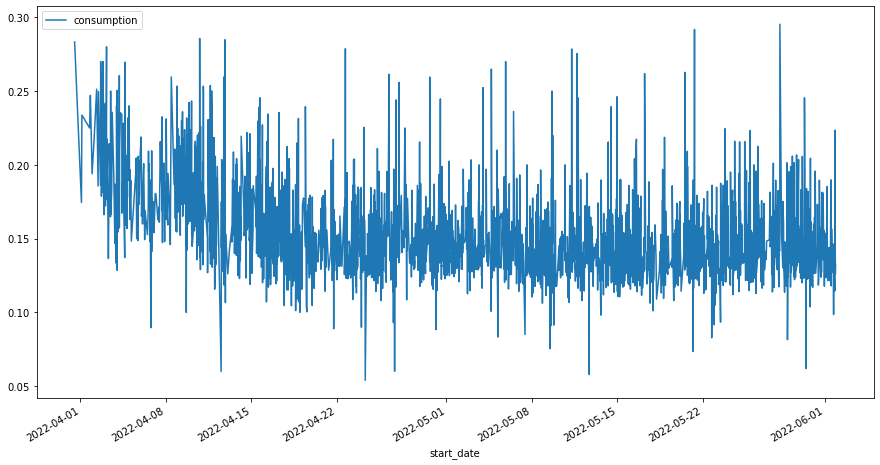

In [41]:
sessions_df[sessions_df['distance']!=0][sessions_df['battery_used']>0][sessions_df['consumption']<0.3][sessions_df['consumption']>0.05].plot(x='start_date', y='consumption', figsize=(15, 8))

<AxesSubplot:xlabel='start_date'>

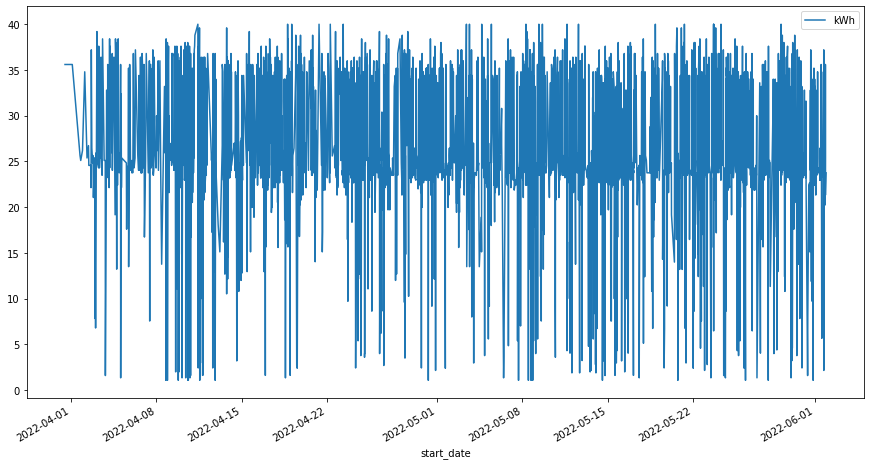

In [42]:
sessions_df[sessions_df['distance']!=0][sessions_df['battery_used']>0][sessions_df['consumption']<0.3][sessions_df['consumption']>0.05].plot(x='start_date', y='kWh', figsize=(15, 8))

In [43]:
sessions_df[sessions_df['distance']!=0][sessions_df['battery_used']>0][sessions_df['consumption']<0.3][sessions_df['consumption']>0.05]['kWh'].describe()

count    3428.000000
mean       26.160928
std         7.449659
min         1.080000
25%        23.490000
50%        24.840000
75%        33.200000
max        40.000000
Name: kWh, dtype: float64

In [44]:
other_df = sessions_df[sessions_df['distance']<50][sessions_df['delta']<20]

In [45]:
other_df

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,driver,mileage,delta,...,day,created_id,last_mileage,last_plate,distance,site,kWh,kWh_used,battery_used,consumption
43,FB-797-JS,ZOE,2022-04-07 17:58:18,2022-04-07 18:06:09,90.0,100.0,"22 Rue Yves Kermen, 92100 Boulogne-Billancourt...",florian arnault,13699.0,10.0,...,97,FB-797-JSflorian arnault97,16471.0,FB-802-ZW,0.0,NO MATCH,4.00,4.00,10.0,inf
100,FZ-804-RF,Spring,2022-05-20 03:12:00,2022-05-20 03:31:00,93.0,99.0,"54 Rue du Moulin des Prés, 75013 Paris, France",Joseph Pagal,6056.0,6.0,...,140,FZ-804-RFJoseph Pagal140,6056.0,FZ-804-RF,0.0,BMP - Paripark - Moulin des Près - Paris | 62 ...,1.62,0.00,0.0,NaN
274,FZ-910-RF,Spring,2022-05-13 22:41:00,2022-05-14 00:11:00,45.0,62.0,"25 Rue Geoffroy-Saint-Hilaire, 75005 Paris, Fr...",Alexandre Makunga,5557.0,17.0,...,133,FZ-910-RFAlexandre Makunga133,5557.0,FZ-910-RF,0.0,BMP - Paripark - Jardin des Plantes - Paris | ...,4.59,0.00,0.0,NaN
275,FZ-910-RF,Spring,2022-05-14 00:12:00,2022-05-14 01:02:00,62.0,77.0,"25 Rue Geoffroy-Saint-Hilaire, 75005 Paris, Fr...",Alexandre Makunga,5557.0,15.0,...,134,FZ-910-RFAlexandre Makunga134,5557.0,FZ-910-RF,0.0,BMP - Paripark - Jardin des Plantes - Paris | ...,4.05,0.00,0.0,NaN
313,FZ-386-RF,Spring,2022-04-24 08:12:39,2022-04-24 11:19:21,91.0,100.0,"7 Rue Gabriel Péri, 92110 Clichy, France",Ivan Mvibudulu Nganga,5379.0,9.0,...,114,FZ-386-RFIvan Mvibudulu Nganga114,5334.0,FZ-386-RF,45.0,NO MATCH,2.43,2.43,9.0,0.054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,GB-888-JX,Spring,2022-05-22 18:45:00,2022-05-22 20:24:00,41.0,50.0,15 Rue Censier Parking du jardin des plantes A...,Alexandre Makunga,2739.0,9.0,...,142,GB-888-JXAlexandre Makunga142,2739.0,GB-888-JX,0.0,BMP - Paripark - Jardin des Plantes - Paris | ...,2.43,0.00,0.0,NaN
8768,GB-888-JX,Spring,2022-05-22 20:26:00,2022-05-22 21:22:00,48.0,61.0,15 Rue Censier Parking du jardin des plantes A...,Alexandre Makunga,2739.0,13.0,...,142,GB-888-JXAlexandre Makunga142,2739.0,GB-888-JX,0.0,BMP - Paripark - Jardin des Plantes - Paris | ...,3.51,0.54,2.0,inf
8770,GB-888-JX,Spring,2022-05-22 22:08:00,2022-05-22 22:34:00,81.0,100.0,15 Rue Censier Parking du jardin des plantes A...,Alexandre Makunga,2739.0,19.0,...,142,GB-888-JXAlexandre Makunga142,2739.0,GB-888-JX,0.0,BMP - Paripark - Jardin des Plantes - Paris | ...,5.13,0.00,0.0,NaN
8844,GD-650-TQ,Spring,2022-05-17 13:09:00,2022-05-17 13:41:00,88.0,100.0,"21 Rue de lÉcole de Médecine, 75006 Paris, France",luc talbot,720.0,12.0,...,137,GD-650-TQluc talbot137,722.0,GD-650-TQ,-2.0,SAEMES/SAE-EDM | 21 Rue de l'École de Médecine,3.24,0.00,0.0,-0.000


In [46]:
plate = 'FZ-883-RF'
sessions_df[sessions_df['plate_number']==plate]

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,driver,mileage,delta,...,day,created_id,last_mileage,last_plate,distance,site,kWh,kWh_used,battery_used,consumption
9054,FZ-883-RF,Spring,2022-05-07 10:54:00,2022-05-07 18:11:00,9.0,100.0,15 Rue Censier Parking du jardin des plantes A...,Romain Sannajust,3072.0,91.0,...,127,FZ-883-RFRomain Sannajust127,4798.0,FZ-176-RF,0.0,BMP - Paripark - Jardin des Plantes - Paris | ...,24.57,23.76,88.0,inf
9055,FZ-883-RF,Spring,2022-05-09 08:11:00,2022-05-09 16:09:00,3.0,100.0,"43 Rue Olivier Métra, 75020 Paris, France",Abou DIABY,3294.0,97.0,...,129,FZ-883-RFAbou DIABY129,3072.0,FZ-883-RF,222.0,BMP - Paripark - Olivier Metra - Paris | 35-49...,26.19,26.19,97.0,0.117973
9059,FZ-883-RF,Spring,2022-05-19 16:46:00,2022-05-19 20:29:00,11.0,100.0,"34 All. des Frères Voisin, 75015 Paris, France",Madil Berkani,3486.0,89.0,...,139,FZ-883-RFMadil Berkani139,3294.0,FZ-883-RF,192.0,Freshmile/SUERDA | 26 Allée des Frères Voisin,24.03,24.03,89.0,0.125156
9060,FZ-883-RF,Spring,2022-05-31 05:19:00,2022-05-31 06:33:00,13.0,99.0,"11 Voie Voie Provisoire BV/17, 75017 Paris, Fr...",hicham boulahtit,3606.0,86.0,...,151,FZ-883-RFhicham boulahtit151,3486.0,FZ-883-RF,120.0,NO MATCH,23.22,23.49,87.0,0.195750


In [47]:
dataframe = df[df['plate_number']==plate].head(60)
dataframe

,plate_number,driver,start_adress,end_adress,mileage_start,mileage_end,booking_end_date__date,booking_start_date__date,battery_level_at_start,battery_level_at_end,car_model,booking_id,start_date_time,end_date_time,charging,delta,month
39922,FZ-883-RF,Zity Paris 1,"XVM6+56 Flins-sur-Seine, France","6 Pl. Saint-Augustin, 75008 Paris, France",2902.0,2955.0,5/5/2022 3:24:00 PM,5/5/2022 1:55:00 PM,100,73,Spring,RZTY9129513,2022-05-05 13:55:00,2022-05-05 15:24:00,False,-27,Mai
62489,FZ-883-RF,Client,"6 Pl. Saint-Augustin, 75008 Paris, France","Docteur Mignot-Guinet, 11 Rue Félix Faure, 750...",2955.0,2969.0,5/6/2022 12:41:00 AM,5/6/2022 12:04:00 AM,73,67,Spring,RZTY9132386,2022-05-06 00:04:00,2022-05-06 00:41:00,False,-6,Mai
34645,FZ-883-RF,Client,"Docteur Mignot-Guinet, 11 Rue Félix Faure, 750...","Javel train station, 75015 Paris, France",2969.0,2975.0,5/6/2022 5:29:00 AM,5/6/2022 5:05:00 AM,67,63,Spring,RZTY9132824,2022-05-06 05:05:00,2022-05-06 05:29:00,False,-4,Mai
34635,FZ-883-RF,Client,"Javel train station, 75015 Paris, France","1 Rue Georges Duhamel, 75015 Paris, France",2975.0,2984.0,5/6/2022 9:07:00 AM,5/6/2022 6:12:00 AM,62,57,Spring,RZTY9132901,2022-05-06 06:12:00,2022-05-06 09:07:00,False,-5,Mai
13700,FZ-883-RF,Client,"1 Rue Georges Duhamel, 75015 Paris, France","1P Pl. de Brazzaville, 75015 Paris, France",2984.0,3002.0,5/6/2022 5:25:00 PM,5/6/2022 9:08:00 AM,57,46,Spring,RZTY9133554,2022-05-06 09:08:00,2022-05-06 17:25:00,False,-11,Mai
18640,FZ-883-RF,Client,"1P Pl. de Brazzaville, 75015 Paris, France","28 Rue Jean Colly, 75013 Paris, France",3002.0,3059.0,5/7/2022 1:25:00 AM,5/6/2022 5:25:00 PM,46,15,Spring,RZTY9135782,2022-05-06 17:25:00,2022-05-07 01:25:00,False,-31,Mai
1226,FZ-883-RF,Client,"28 Rue Jean Colly, 75013 Paris, France","28 Rue Jean Colly, 75013 Paris, France",3059.0,3059.0,5/7/2022 1:38:00 AM,5/7/2022 1:25:00 AM,15,15,Spring,RZTY9138609,2022-05-07 01:25:00,2022-05-07 01:38:00,False,0,Mai
76816,FZ-883-RF,Van Huy NGUYEN,"28 Rue Jean Colly, 75013 Paris, France","28 Rue Jean Colly, 75013 Paris, France",3061.0,3061.0,5/7/2022 1:53:00 AM,5/7/2022 1:53:00 AM,14,14,Spring,RZTY9138720,2022-05-07 01:53:00,2022-05-07 01:53:00,False,0,Mai
61966,FZ-883-RF,Lassana Cissako,"28 Rue Jean Colly, 75013 Paris, France","28 Rue Jean Colly, 75013 Paris, France",3061.0,3061.0,5/7/2022 3:30:00 AM,5/7/2022 3:26:00 AM,14,14,Spring,RZTY9138965,2022-05-07 03:26:00,2022-05-07 03:30:00,False,0,Mai
59795,FZ-883-RF,Client,"28 Rue Jean Colly, 75013 Paris, France","13P Rue du Charolais, 75012 Paris, France",3061.0,3063.0,5/7/2022 4:03:00 AM,5/7/2022 3:41:00 AM,14,13,Spring,RZTY9138989,2022-05-07 03:41:00,2022-05-07 04:03:00,False,-1,Mai


In [48]:
dataframe.reset_index(drop=True, inplace=True)
plate = dataframe.loc[0, 'plate_number']
model = dataframe.loc[0, 'car_model']
dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
for index in range(len(dataframe)):
    if dataframe.loc[index, 'battery_drop']/(dataframe.loc[index, 'delta_hours']+1) > 5:
            dataframe.loc[index, 'battery_level_at_start'] = dataframe.loc[index, 'last_end_battery']
            dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
            dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
            dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
            dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
            dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
            dataframe['delta'] = dataframe['battery_level_at_end']-dataframe['battery_level_at_start']
    if (dataframe.loc[index, 'battery_level_at_start'] - dataframe.loc[index, 'battery_level_at_end'])/(dataframe.loc[index, 'duration']+1)>30:
            dataframe.loc[index, 'battery_level_at_end'] = dataframe.loc[index, 'battery_level_at_start']
            dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
            dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
            dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
            dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
            dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
            dataframe['delta'] = dataframe['battery_level_at_end']-dataframe['battery_level_at_start']


In [49]:
dataframe

,plate_number,driver,start_adress,end_adress,mileage_start,mileage_end,booking_end_date__date,booking_start_date__date,battery_level_at_start,battery_level_at_end,...,start_date_time,end_date_time,charging,delta,month,last_end_battery,last_end_date,delta_hours,duration,battery_drop
0,FZ-883-RF,Zity Paris 1,"XVM6+56 Flins-sur-Seine, France","6 Pl. Saint-Augustin, 75008 Paris, France",2902.0,2955.0,5/5/2022 3:24:00 PM,5/5/2022 1:55:00 PM,100,73,...,2022-05-05 13:55:00,2022-05-05 15:24:00,False,-27,Mai,NaN,NaT,NaN,1.0,NaN
1,FZ-883-RF,Client,"6 Pl. Saint-Augustin, 75008 Paris, France","Docteur Mignot-Guinet, 11 Rue Félix Faure, 750...",2955.0,2969.0,5/6/2022 12:41:00 AM,5/6/2022 12:04:00 AM,73,67,...,2022-05-06 00:04:00,2022-05-06 00:41:00,False,-6,Mai,73.0,2022-05-05 15:24:00,8.0,0.0,0.0
2,FZ-883-RF,Client,"Docteur Mignot-Guinet, 11 Rue Félix Faure, 750...","Javel train station, 75015 Paris, France",2969.0,2975.0,5/6/2022 5:29:00 AM,5/6/2022 5:05:00 AM,67,63,...,2022-05-06 05:05:00,2022-05-06 05:29:00,False,-4,Mai,67.0,2022-05-06 00:41:00,4.0,0.0,0.0
3,FZ-883-RF,Client,"Javel train station, 75015 Paris, France","1 Rue Georges Duhamel, 75015 Paris, France",2975.0,2984.0,5/6/2022 9:07:00 AM,5/6/2022 6:12:00 AM,62,57,...,2022-05-06 06:12:00,2022-05-06 09:07:00,False,-5,Mai,63.0,2022-05-06 05:29:00,0.0,2.0,1.0
4,FZ-883-RF,Client,"1 Rue Georges Duhamel, 75015 Paris, France","1P Pl. de Brazzaville, 75015 Paris, France",2984.0,3002.0,5/6/2022 5:25:00 PM,5/6/2022 9:08:00 AM,57,46,...,2022-05-06 09:08:00,2022-05-06 17:25:00,False,-11,Mai,57.0,2022-05-06 09:07:00,0.0,8.0,0.0
5,FZ-883-RF,Client,"1P Pl. de Brazzaville, 75015 Paris, France","28 Rue Jean Colly, 75013 Paris, France",3002.0,3059.0,5/7/2022 1:25:00 AM,5/6/2022 5:25:00 PM,46,15,...,2022-05-06 17:25:00,2022-05-07 01:25:00,False,-31,Mai,46.0,2022-05-06 17:25:00,0.0,8.0,0.0
6,FZ-883-RF,Client,"28 Rue Jean Colly, 75013 Paris, France","28 Rue Jean Colly, 75013 Paris, France",3059.0,3059.0,5/7/2022 1:38:00 AM,5/7/2022 1:25:00 AM,15,15,...,2022-05-07 01:25:00,2022-05-07 01:38:00,False,0,Mai,15.0,2022-05-07 01:25:00,0.0,0.0,0.0
7,FZ-883-RF,Van Huy NGUYEN,"28 Rue Jean Colly, 75013 Paris, France","28 Rue Jean Colly, 75013 Paris, France",3061.0,3061.0,5/7/2022 1:53:00 AM,5/7/2022 1:53:00 AM,14,14,...,2022-05-07 01:53:00,2022-05-07 01:53:00,False,0,Mai,15.0,2022-05-07 01:38:00,0.0,0.0,1.0
8,FZ-883-RF,Lassana Cissako,"28 Rue Jean Colly, 75013 Paris, France","28 Rue Jean Colly, 75013 Paris, France",3061.0,3061.0,5/7/2022 3:30:00 AM,5/7/2022 3:26:00 AM,14,14,...,2022-05-07 03:26:00,2022-05-07 03:30:00,False,0,Mai,14.0,2022-05-07 01:53:00,1.0,0.0,0.0
9,FZ-883-RF,Client,"28 Rue Jean Colly, 75013 Paris, France","13P Rue du Charolais, 75012 Paris, France",3061.0,3063.0,5/7/2022 4:03:00 AM,5/7/2022 3:41:00 AM,14,13,...,2022-05-07 03:41:00,2022-05-07 04:03:00,False,-1,Mai,14.0,2022-05-07 03:30:00,0.0,0.0,0.0


In [50]:
"""dataframe.reset_index(drop=True, inplace=True)
dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
dataframe['was_charging']=(dataframe['battery_level_at_start']-dataframe['last_end_battery']>0)
dataframe["charging"] = (dataframe['battery_level_at_end']-dataframe['battery_level_at_start']>=0)
charging_sessions = []
index = 0
current_start = 0
start = ""
start_battery = 0
current_last = 0
open_booking = False
while index < len(dataframe) :
    if open_booking: # car was charging
        if not dataframe.loc[index, 'charging']: # car is not charging anymore --> close session
            open_booking = False
            if dataframe.loc[index, 'was_charging']:
                charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index, 'start_date_time'], start_battery, dataframe.loc[index, 'battery_level_at_start'], dataframe.loc[index-1, 'start_adress'], dataframe.loc[index-1, 'driver'], dataframe.loc[index-1, 'mileage_end']))
            else :
                charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index-1, 'start_date_time'], start_battery, dataframe.loc[current_last, 'battery_level_at_end'], dataframe.loc[index-1, 'start_adress'], dataframe.loc[index-1, 'driver'], dataframe.loc[index-1, 'mileage_end']))
        else : # car is still charging
                current_last = index
    else : # car wasn't charging
        if dataframe.loc[index, 'was_charging']: # the car was charged since last booking
            open_booking = True
            current_start = index-1
            start = 'end_'
            current_last = index
            start_battery = dataframe.loc[current_start, 'battery_level_at_end']
            if not dataframe.loc[index, 'charging']: # car is not charging anymore --> close session
                open_booking = False
                charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index, 'start_date_time'], start_battery, dataframe.loc[index, 'battery_level_at_start'], dataframe.loc[current_start, 'end_adress'], dataframe.loc[index-1, 'driver'], dataframe.loc[index-1, 'mileage_end']))
        else :
            if dataframe.loc[index, 'charging']:
                open_booking = True
                current_start = index
                start = "start_"
                current_last = index
                start_battery = dataframe.loc[index, 'battery_level_at_start']
        index += 1"""

'dataframe.reset_index(drop=True, inplace=True)\ndataframe[\'last_end_battery\']=dataframe[\'battery_level_at_end\'].shift(1)\ndataframe[\'was_charging\']=(dataframe[\'battery_level_at_start\']-dataframe[\'last_end_battery\']>0)\ndataframe["charging"] = (dataframe[\'battery_level_at_end\']-dataframe[\'battery_level_at_start\']>=0)\ncharging_sessions = []\nindex = 0\ncurrent_start = 0\nstart = ""\nstart_battery = 0\ncurrent_last = 0\nopen_booking = False\nwhile index < len(dataframe) :\n    if open_booking: # car was charging\n        if not dataframe.loc[index, \'charging\']: # car is not charging anymore --> close session\n            open_booking = False\n            if dataframe.loc[index, \'was_charging\']:\n                charging_sessions.append((plate, model, dataframe.loc[current_start, start+\'date_time\'], dataframe.loc[index, \'start_date_time\'], start_battery, dataframe.loc[index, \'battery_level_at_start\'], dataframe.loc[index-1, \'start_adress\'], dataframe.loc[index-1

In [51]:
dataframe

,plate_number,driver,start_adress,end_adress,mileage_start,mileage_end,booking_end_date__date,booking_start_date__date,battery_level_at_start,battery_level_at_end,...,start_date_time,end_date_time,charging,delta,month,last_end_battery,last_end_date,delta_hours,duration,battery_drop
0,FZ-883-RF,Zity Paris 1,"XVM6+56 Flins-sur-Seine, France","6 Pl. Saint-Augustin, 75008 Paris, France",2902.0,2955.0,5/5/2022 3:24:00 PM,5/5/2022 1:55:00 PM,100,73,...,2022-05-05 13:55:00,2022-05-05 15:24:00,False,-27,Mai,NaN,NaT,NaN,1.0,NaN
1,FZ-883-RF,Client,"6 Pl. Saint-Augustin, 75008 Paris, France","Docteur Mignot-Guinet, 11 Rue Félix Faure, 750...",2955.0,2969.0,5/6/2022 12:41:00 AM,5/6/2022 12:04:00 AM,73,67,...,2022-05-06 00:04:00,2022-05-06 00:41:00,False,-6,Mai,73.0,2022-05-05 15:24:00,8.0,0.0,0.0
2,FZ-883-RF,Client,"Docteur Mignot-Guinet, 11 Rue Félix Faure, 750...","Javel train station, 75015 Paris, France",2969.0,2975.0,5/6/2022 5:29:00 AM,5/6/2022 5:05:00 AM,67,63,...,2022-05-06 05:05:00,2022-05-06 05:29:00,False,-4,Mai,67.0,2022-05-06 00:41:00,4.0,0.0,0.0
3,FZ-883-RF,Client,"Javel train station, 75015 Paris, France","1 Rue Georges Duhamel, 75015 Paris, France",2975.0,2984.0,5/6/2022 9:07:00 AM,5/6/2022 6:12:00 AM,62,57,...,2022-05-06 06:12:00,2022-05-06 09:07:00,False,-5,Mai,63.0,2022-05-06 05:29:00,0.0,2.0,1.0
4,FZ-883-RF,Client,"1 Rue Georges Duhamel, 75015 Paris, France","1P Pl. de Brazzaville, 75015 Paris, France",2984.0,3002.0,5/6/2022 5:25:00 PM,5/6/2022 9:08:00 AM,57,46,...,2022-05-06 09:08:00,2022-05-06 17:25:00,False,-11,Mai,57.0,2022-05-06 09:07:00,0.0,8.0,0.0
5,FZ-883-RF,Client,"1P Pl. de Brazzaville, 75015 Paris, France","28 Rue Jean Colly, 75013 Paris, France",3002.0,3059.0,5/7/2022 1:25:00 AM,5/6/2022 5:25:00 PM,46,15,...,2022-05-06 17:25:00,2022-05-07 01:25:00,False,-31,Mai,46.0,2022-05-06 17:25:00,0.0,8.0,0.0
6,FZ-883-RF,Client,"28 Rue Jean Colly, 75013 Paris, France","28 Rue Jean Colly, 75013 Paris, France",3059.0,3059.0,5/7/2022 1:38:00 AM,5/7/2022 1:25:00 AM,15,15,...,2022-05-07 01:25:00,2022-05-07 01:38:00,False,0,Mai,15.0,2022-05-07 01:25:00,0.0,0.0,0.0
7,FZ-883-RF,Van Huy NGUYEN,"28 Rue Jean Colly, 75013 Paris, France","28 Rue Jean Colly, 75013 Paris, France",3061.0,3061.0,5/7/2022 1:53:00 AM,5/7/2022 1:53:00 AM,14,14,...,2022-05-07 01:53:00,2022-05-07 01:53:00,False,0,Mai,15.0,2022-05-07 01:38:00,0.0,0.0,1.0
8,FZ-883-RF,Lassana Cissako,"28 Rue Jean Colly, 75013 Paris, France","28 Rue Jean Colly, 75013 Paris, France",3061.0,3061.0,5/7/2022 3:30:00 AM,5/7/2022 3:26:00 AM,14,14,...,2022-05-07 03:26:00,2022-05-07 03:30:00,False,0,Mai,14.0,2022-05-07 01:53:00,1.0,0.0,0.0
9,FZ-883-RF,Client,"28 Rue Jean Colly, 75013 Paris, France","13P Rue du Charolais, 75012 Paris, France",3061.0,3063.0,5/7/2022 4:03:00 AM,5/7/2022 3:41:00 AM,14,13,...,2022-05-07 03:41:00,2022-05-07 04:03:00,False,-1,Mai,14.0,2022-05-07 03:30:00,0.0,0.0,0.0


In [52]:
pd.DataFrame(charging_sessions).head(10)

NameError: name 'charging_sessions' is not defined

In [53]:
sessions_df[sessions_df['plate_number']=='FB-226-HW'].head(10)

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,driver,mileage,delta,...,day,created_id,last_mileage,last_plate,distance,site,kWh,kWh_used,battery_used,consumption
60,FB-226-HW,ZOE,2022-03-30 03:00:52,2022-03-30 05:54:45,12.0,100.0,"62 Rue du Moulin des Prés, 75013 Paris, France",Solal Cuinet,19489.0,88.0,...,89,FB-226-HWSolal Cuinet89,15219.0,FB-797-JS,0.0,BMP - Paripark - Moulin des Près - Paris | 62 ...,35.2,35.2,88.0,inf
61,FB-226-HW,ZOE,2022-04-03 20:00:04,2022-04-03 22:09:55,14.0,18.0,"12 Rue Darmesteter, 75013 Paris, France",Client,19673.0,4.0,...,93,FB-226-HWClient93,19489.0,FB-226-HW,184.0,NO MATCH,1.6,34.4,86.0,0.186957
62,FB-226-HW,ZOE,2022-04-03 22:31:44,2022-04-04 00:28:13,17.0,99.0,"54 Rue du Moulin des Prés, 75013 Paris, France",Ronald Rigah Jonathan,19676.0,82.0,...,93,FB-226-HWRonald Rigah Jonathan93,19673.0,FB-226-HW,3.0,BMP - Paripark - Moulin des Près - Paris | 62 ...,32.8,0.4,1.0,0.133333
66,FB-226-HW,ZOE,2022-04-13 22:47:22,2022-04-14 00:59:52,10.0,97.0,"25 Rue Geoffroy-Saint-Hilaire, 75005 Paris, Fr...",Paul Millet,19878.0,87.0,...,103,FB-226-HWPaul Millet103,19676.0,FB-226-HW,202.0,BMP - Paripark - Jardin des Plantes - Paris | ...,34.8,35.6,89.0,0.176238
68,FB-226-HW,ZOE,2022-04-24 02:27:56,2022-04-24 14:14:53,12.0,100.0,"62 Rue du Moulin des Prés, 75013 Paris, France",Djegui Toure,20088.0,88.0,...,114,FB-226-HWDjegui Toure114,19878.0,FB-226-HW,210.0,BMP - Paripark - Moulin des Près - Paris | 62 ...,35.2,34.0,85.0,0.161905
72,FB-226-HW,ZOE,2022-04-28 08:01:00,2022-04-28 11:07:00,1.0,100.0,"36 Rue Olivier Métra, 75020 Paris, France",Mohamadou Niakate,20204.0,99.0,...,118,FB-226-HWMohamadou Niakate118,20088.0,FB-226-HW,116.0,BMP - Paripark - Olivier Metra - Paris | 35-49...,39.6,39.6,99.0,0.341379
75,FB-226-HW,ZOE,2022-05-06 15:34:00,2022-05-06 17:50:00,10.0,100.0,"25 Rue Geoffroy-Saint-Hilaire, 75005 Paris, Fr...",Herve BWASI-LUBAYA,20477.0,90.0,...,126,FB-226-HWHerve BWASI-LUBAYA126,20204.0,FB-226-HW,273.0,BMP - Paripark - Jardin des Plantes - Paris | ...,36.0,36.0,90.0,0.131868
78,FB-226-HW,ZOE,2022-05-16 08:57:00,2022-05-16 09:02:00,16.0,90.0,"4Z Rue Christine de Pisan, 75017 Paris, France",Van Huy NGUYEN,20714.0,74.0,...,136,FB-226-HWVan Huy NGUYEN136,20477.0,FB-226-HW,237.0,BMP - Parking AVE - 17e | 7 Rue Christine de P...,29.6,33.6,84.0,0.141772


In [54]:
sessions_df['driver'].value_counts()

Van Huy NGUYEN                 605
Madil Berkani                  343
Moke N Kazi                    326
Mathias Riguet                 261
Client                         236
                              ... 
cedric IFERSENE (Zity Lyon)      1
Zakaria Kochtali                 1
Aude Chatelard                   1
Alan Norez                       1
Zity Paris 2                     1
Name: driver, Length: 74, dtype: int64

In [55]:
sessions_df[sessions_df['model']=='ZOE']['kWh'].describe()

count    1467.000000
mean       31.785958
std         8.189801
min         1.600000
25%        32.000000
50%        34.400000
75%        36.000000
max        40.000000
Name: kWh, dtype: float64

In [56]:
sessions_df[sessions_df['driver']=="Client"]['kWh'].sum()

3784.6499999999996

In [57]:
sessions_df['kWh']=pd.to_numeric(sessions_df['kWh'])

In [58]:
sessions_df['kWh_used']=pd.to_numeric(sessions_df['kWh_used'])

In [59]:
sessions_df[sessions_df['consumption']<0.20][sessions_df['consumption']>0.10]

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,driver,mileage,delta,...,day,created_id,last_mileage,last_plate,distance,site,kWh,kWh_used,battery_used,consumption
7,FB-386-YK,ZOE,2022-04-11 20:19:00,2022-04-13 19:55:24,15.0,100.0,"5bis Rue Mahias, 92100 Boulogne-Billancourt, F...",Madil Berkani,16107.0,85.0,...,101,FB-386-YKMadil Berkani101,15945.0,FB-386-YK,162.0,NO MATCH,34.00,28.00,70.0,0.172840
9,FB-386-YK,ZOE,2022-04-18 16:39:24,2022-04-19 19:16:26,14.0,100.0,"12 Rue de lÉcole de Médecine, 75006 Paris, France",Alexandre Makunga,16339.0,86.0,...,108,FB-386-YKAlexandre Makunga108,16107.0,FB-386-YK,232.0,SAEMES/SAE-EDM | 21 Rue de l'École de Médecine,34.40,34.40,86.0,0.148276
10,FB-386-YK,ZOE,2022-04-24 19:18:29,2022-04-25 17:40:24,14.0,100.0,"40ter Rue Olivier Métra, 75020 Paris, France",Daniel Da Silva Meneses Campos,16579.0,86.0,...,114,FB-386-YKDaniel Da Silva Meneses Campos114,16339.0,FB-386-YK,240.0,BMP - Paripark - Olivier Metra - Paris | 35-49...,34.40,34.40,86.0,0.143333
17,FB-386-YK,ZOE,2022-05-09 16:52:00,2022-05-16 12:18:00,16.0,99.0,"79 Pl. Saint-Jacques, 75014 Paris, France",Zity Paris 1,16784.0,83.0,...,129,FB-386-YKZity Paris 1129,16579.0,FB-386-YK,205.0,NO MATCH,33.20,33.60,84.0,0.163902
18,FB-386-YK,ZOE,2022-05-18 01:27:00,2022-05-18 04:08:00,13.0,100.0,"37 Rue Olivier Métra, 75020 Paris, France",Joseph Pagal,17024.0,87.0,...,138,FB-386-YKJoseph Pagal138,16784.0,FB-386-YK,240.0,BMP - Paripark - Olivier Metra - Paris | 35-49...,34.80,34.40,86.0,0.143333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9066,GB-945-JX,Spring,2022-05-09 22:35:00,2022-05-10 00:18:00,12.0,100.0,"25 Rue Geoffroy-Saint-Hilaire, 75005 Paris, Fr...",Jean Marc Evan Randriamahazomanana,1698.0,88.0,...,129,GB-945-JXJean Marc Evan Randriamahazomanana 129,1564.0,GB-945-JX,134.0,BMP - Paripark - Jardin des Plantes - Paris | ...,23.76,17.82,66.0,0.132985
9068,GB-945-JX,Spring,2022-05-15 13:05:00,2022-05-15 14:51:00,11.0,48.0,"12 Rue Censier, 75005 Paris, France",Client,1902.0,37.0,...,135,GB-945-JXClient135,1698.0,GB-945-JX,204.0,BMP - Paripark - Jardin des Plantes - Paris | ...,9.99,24.03,89.0,0.117794
9071,GB-945-JX,Spring,2022-05-23 12:42:00,2022-05-23 14:14:00,11.0,100.0,"6 Rue Santeuil, 75005 Paris, France",Client,2087.0,89.0,...,143,GB-945-JXClient143,1902.0,GB-945-JX,185.0,NO MATCH,24.03,24.03,89.0,0.129892
9072,GB-945-JX,Spring,2022-05-29 00:59:00,2022-05-29 02:25:00,6.0,100.0,"4 Rue Christine de Pisan, 75017 Paris, France",hicham boulahtit,2276.0,94.0,...,149,GB-945-JXhicham boulahtit149,2087.0,GB-945-JX,189.0,BMP - Parking AVE - 17e | 7 Rue Christine de P...,25.38,25.38,94.0,0.134286


In [60]:
sessions_df['consumption'].value_counts()

 inf         517
 0.135000     35
-0.000000     28
 0.133333     11
 0.150000     10
            ... 
 0.173444      1
 0.164912      1
 0.112601      1
 0.123636      1
 0.129685      1
Name: consumption, Length: 2134, dtype: int64

In [141]:
sessions_df[sessions_df['site']!='NO MATCH'][sessions_df['month']!='Mai']['kWh'].sum()

48748.880000000005

In [137]:
liste = (sessions_df['adress'][sessions_df["site"]=="NO MATCH"].str[4:].value_counts())
liste.head(30)

d Lefebvre, 75015 Paris, France                      13
e du Gril, 75005 Paris, France                        9
v. du Général Leclerc, 93500 Pantin, France           8
ue des Ardennes, 75019 Paris, France                  5
ue Levert, 75020 Paris, France                        5
. Paul Paray, 75017 Paris, France                     5
e des Fossés Saint-Marcel, 75005 Paris, France        4
Bd Victor Hugo, 92110 Clichy, France                  4
ass. Foubert, 75013 Paris, France                     4
ue Pixérécourt, 75020 Paris, France                   4
ue des Tapisseries, 75017 Paris, France               4
e de Ste Hélène, 75013 Paris, France                  4
v. du Général Galliéni, 92190 Meudon, France          4
+7J Flins-sur-Seine, France                           4
e de la Tacherie, 75004 Paris, France                 4
e Marceau, 92130 Issy-les-Moulineaux, France          4
. de la Prte de Vitry, 75013 Paris, France            3
. Paul Verlaine, 75013 Paris, France            

In [63]:
print(type(liste))

<class 'pandas.core.series.Series'>


In [64]:
sessions_df.to_csv("charging_sessions2.csv")